# Recurrent Neural Network to Predict Stock Prices

https://github.com/kimanalytics/Recurrent-Neural-Network-to-Predict-Stock-Prices

http://cs229.stanford.edu/proj2012/BernalFokPidaparthi-FinancialMarketTimeSeriesPredictionwithRecurrentNeural.pdf

https://finance.yahoo.com/quote/TSLA/history?p=TSLA

In [1]:
!pip install -q matplotlib pandas sklearn

In [2]:
import math
import pdb # debugger

import tensorflow as tf
import tensorflow.keras as ks
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sklearn as sk
from sklearn.preprocessing import MinMaxScaler

# Reproducibilty
np.random.seed(7)
        
def get_percentage_index(l, p):
    return int(math.floor(len(l) / 100 * p))

In [3]:
scaler = MinMaxScaler()
model = ks.models.Sequential()
model.add(ks.layers.LSTM(units = 4, activation  = 'sigmoid', input_shape = (None, 1)))
model.add(ks.layers.Dense(units = 1))
model.compile(
    optimizer = 'adam',
    loss = 'mean_squared_error',
    metrics = ['accuracy']
)

In [4]:
data = pd.read_csv('https://stooq.com/q/d/l/?s=^aex&i=d')
data = data[get_percentage_index(data, 50):]

In [5]:
data_transformed = data['Close'].values
data_transformed = [[x] for x in data_transformed]
data_transformed = scaler.fit_transform(data_transformed)

In [6]:
training_index = get_percentage_index(data, 20)
data_testing = data_transformed[training_index:]
data_training = data_transformed[:training_index]
data_training_inputs = data_training[0:len(data_training) - 5]
data_training_targets = data_training[5:len(data_training)]

In [7]:
X = np.reshape(data_training_inputs, (len(data_training_inputs), 1, 1))
Y = data_training_targets

In [8]:
result_training = model.fit(
    X,
    Y,
    verbose = 0,
    batch_size = 50,
    epochs = 200
)

895/895 [==============================] - 0s 214us/step
Scores:

acc: 0.11%


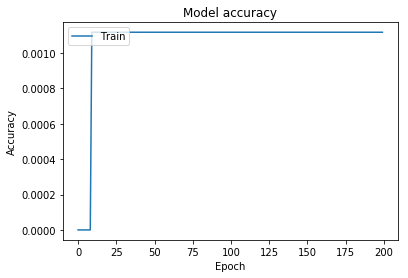

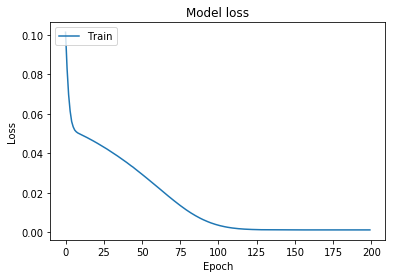

In [9]:
scores = model.evaluate(X, Y)
print("Scores:")
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

# pdb.set_trace()

# Plot training & validation accuracy values
plt.plot(result_training.history['acc'])
#plt.plot(result_training.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(result_training.history['loss'])
#plt.plot(result_training.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [10]:
tf.contrib.saved_model.save_keras_model(
    model,
    "models/test1",
    custom_objects=None,
    as_text=None
)


Consider using a TensorFlow optimizer from `tf.train`.
INFO:tensorflow:Signatures INCLUDED in export for Eval: None
INFO:tensorflow:Signatures INCLUDED in export for Classify: None
INFO:tensorflow:Signatures INCLUDED in export for Regress: None
INFO:tensorflow:Signatures INCLUDED in export for Predict: ['serving_default']
INFO:tensorflow:Signatures INCLUDED in export for Train: None
INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: models/test1/temp-1546473965/saved_model.pb


'models/test1/1546473965'

In [ ]:
data_testing_prediction = model.predict(np.reshape(data_testing, (len(data_testing), 1, 1)))

In [ ]:
plot_testing = [x[0] for x in scaler.inverse_transform(data_testing)]
plot_prediction = [x[0] for x in scaler.inverse_transform(data_testing_prediction)]

# show beginning
# plot_testing = plot_testing[0:10]
# plot_prediction = plot_prediction[0:10]

# show end
# plot_testing = plot_testing[len(plot_testing) - 10:]
# plot_prediction = plot_prediction[len(plot_prediction) - 10:]

plt.plot(plot_testing, color = 'black', label = 'Prices')
plt.plot(plot_prediction, color = 'red', label = 'Prediction')
plt.title('Prediction')
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend()
plt.show()

In [ ]:
table_testing = [x[0] for x in scaler.inverse_transform(data_testing)]
table_prediction = [x[0] for x in scaler.inverse_transform(data_testing_prediction)]

table = pd.DataFrame(
    data = {
        'Date': pd.to_datetime(data['Date'], format='%Y-%m-%d'),
        'Close': data['Close'],
        'Prediction': [None for x in data_training] + plot_prediction
    },
    columns = ['Date', 'Close', 'Prediction'],
)

table.set_index(['Date'], inplace=True)

table['Difference'] = pd.Series(np.absolute(table['Prediction'] - table['Close'].shift(5)))
table['Correctness %'] = pd.Series(100 - table['Difference'] / table['Close'] * 100)

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(table)

In [ ]:
table.plot()